In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import sklearn
import matplotlib.pyplot as plt
from datetime import datetime
from torch.nn.functional import mse_loss
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary
from sklearn.model_selection import train_test_split
from utils_pp import replace_cell_names_with_id
from utils_pp import Encoder
from utils_pp import EarlyStopper
from torch.utils.tensorboard import SummaryWriter
%load_ext autoreload
%autoreload 2

if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [2]:
columns = ["cell_line", "drugA_name", "drugB_name", "drugA_conc", "drugB_conc", "target"]
df_train = pd.read_csv("../data_raw/oneil.csv", usecols=(1,2,3,4,5,12)).iloc[:,[0,1,3,2,4,5]].set_axis(columns, axis=1)
# df_train["cell_line"]
df_test = pd.read_csv("../data/test_yosua.csv").set_axis(columns + ["std"], axis=1).convert_dtypes()

drug_data = pd.read_pickle("../data/drug_data.pkl.compress", compression="gzip")
cell_data = pd.read_pickle("../data/cell_line_data.pkl.compress", compression="gzip")

df_train = replace_cell_names_with_id(dataframe=df_train, mapping_file="../data/mappingccl.csv")
df_test = replace_cell_names_with_id(dataframe=df_test, mapping_file="../data/mappingccl.csv")
df_train = df_train[df_train.cell_line.isin(cell_data.index)]
df_train, df_val = train_test_split(df_train, test_size=0.2, shuffle=True)
cell_data = cell_data[cell_data.index.isin(pd.concat([df_train.cell_line, df_test.cell_line]))]
drug_data = drug_data[drug_data.index.isin(pd.concat([df_train.drugA_name, df_train.drugB_name,df_test.drugA_name, df_test.drugB_name]))]
print("oneil", df_train.memory_usage().sum()/1e6, df_train.shape,"\n", df_train.dtypes)
print("drug_feat", drug_data.memory_usage().sum()/1e6, drug_data.shape)
print("cell_feat", cell_data.memory_usage().sum()/1e6, cell_data.shape)
drug_length = drug_data.shape[1]
cell_length = cell_data.shape[1]

oneil 13.13536 (234560, 6) 
 cell_line      object
drugA_name     object
drugB_name     object
drugA_conc    float64
drugB_conc    float64
target        float64
dtype: object
drug_feat 0.427236 (42, 2412)
cell_feat 0.686136 (32, 5011)


In [3]:
class Dataset_from_pd(Dataset):
    def __init__(self, drug_comb_data, drug_feat, cell_feat):
        self.drug_comb_data = drug_comb_data.to_numpy()
        self.drug_feat = drug_feat.to_numpy()
        self.cell_feat = cell_feat.to_numpy()
        self.drug_mapping = pd.Series(range(len(self.drug_feat)), index=drug_feat.index).to_dict()
        self.cell_mapping = pd.Series(range(len(self.cell_feat)), index=cell_feat.index).to_dict()
        # print(self.cell_mapping, self.drug_mapping)

        print()
    def __len__(self):
        return len(self.drug_comb_data)
    
    def __getitem__(self, idx):
        combi = self.drug_comb_data[idx]
        drug_A = self.drug_feat[self.drug_mapping[combi[1]]]
        drug_B = self.drug_feat[self.drug_mapping[combi[2]]]
        cell_line = self.cell_feat[self.cell_mapping[combi[0]]]


        return np.concatenate([drug_A, drug_B, cell_line, combi[3:5].astype("float32")], dtype="float32"), combi[5:6].astype("float32")

train_set  = Dataset_from_pd(df_train, drug_data, cell_data)
train_dl = DataLoader(train_set, batch_size=256, shuffle=True)
xi, yi = next(iter(train_dl))
print(xi.shape, yi.shape)
# print(np.argwhere(xi>1e2))
# print(tuple(np.argwhere(xi>100)))
print(xi.numpy()[tuple(np.argwhere(xi>100))])
# print(xi.numpy()[:,tuple(np.argwhere(xi>100))[1]])



torch.Size([256, 9837]) torch.Size([256, 1])
[250. 250. 250. 250. 250. 250.]


In [93]:
class AE_DNN(torch.nn.Module):
    def __init__(self, h_sizes):
        super().__init__()
        self.drug_encoder = Encoder(h_sizes=[drug_length, 512, 512, 256, 512, 512])
        self.cell_encoder = Encoder(h_sizes=[cell_length, 512, 512, 256, 512, 512])
        self.hidden = nn.ModuleList()
        for k in range(len(h_sizes)-1):
            self.hidden.append(nn.Linear(h_sizes[k], h_sizes[k+1]))
            self.hidden.append(nn.Dropout(0.1))
            self.hidden.append(nn.ReLU())
        self.hidden.append(nn.Linear(h_sizes[-1], 1))
    def forward(self, x):
        drug_A, drug_B, cell, drugA_conc, drugB_conc = torch.split(x, [drug_length, drug_length, cell_length, 1, 1], dim=1)
        drug_A_emb = self.drug_encoder(drug_A)
        drug_B_emb = self.drug_encoder(drug_B)
        cell_emb = self.cell_encoder(cell)
        x = torch.concatenate([drug_A_emb, drug_B_emb, cell_emb, drugA_conc, drugB_conc], dim=1)
        for lay in self.hidden:
            # print(torch.sum(torch.isnan(x)))
            # print(torch.sum(x>1e3))
            x = lay(x)
        return x
model = AE_DNN([770,32])
yi = model.forward(xi)
print(yi.shape)

torch.Size([256, 1])


In [96]:
def train_one_epoch(model, epoch_index, tb_writer, training_loader, optimizer, loss_fn, device, L1, verbose=False):
    running_loss = 0.
    last_loss = 0.
    model = model.to(device)
    for i, data in enumerate(training_loader):
        inputs, labels = data
        inputs = inputs.to(device=device)
        labels = labels.to(device=device)
        # Zero your gradients for every batch!
        optimizer.zero_grad()
        outputs = model.forward(inputs)

        params = torch.cat([x.view(-1) for x in model.parameters()])
        l1_regularization = L1 * torch.linalg.vector_norm(params, 1)

        # Compute the loss and its gradients
        loss = loss_fn(outputs, labels) + l1_regularization
        loss.backward()

        # Adjust learning weights
        optimizer.step()
        running_loss += loss.item()
        if i % 10 == 9:
            last_loss = running_loss / 10 # loss per batch
            # print('  batch {} loss: {}'.format(i + 1, last_loss), outputs[0][0].item(), labels[0][0].item())
            # tb_x = epoch_index * len(training_loader) + i + 1
            # tb_writer.add_scalar('Loss/train', last_loss, tb_x)
            running_loss = 0.

    return last_loss

In [50]:
path  ="../models/ae_dnn.pt"
torch.save(model.state_dict(), path)

# encoder = Encoder([xi.shape[1],param_dict["first_layer"],512,256], dropout=0)

In [87]:
columns = ["cell_line", "drugA_name", "drugB_name", "drugA_conc", "drugB_conc", "target"]
df_train = pd.read_csv("../data_raw/oneil.csv", usecols=(1,2,3,4,5,12)).iloc[:,[0,1,3,2,4,5]].set_axis(columns, axis=1)
df_test = pd.read_csv("../data/test_yosua.csv").set_axis(columns + ["std"], axis=1).convert_dtypes()
df_train = replace_cell_names_with_id(dataframe=df_train, mapping_file="../data/mappingccl.csv")
df_test = replace_cell_names_with_id(dataframe=df_test, mapping_file="../data/mappingccl.csv")
df_train = df_train[df_train.cell_line.isin(cell_data.index)]

In [184]:
def training(data_train, data_val, L):


    train_set  = Dataset_from_pd(data_train, drug_data, cell_data)
    val_set = Dataset_from_pd(data_val, drug_data, cell_data)
    test_set  = Dataset_from_pd(df_test, drug_data, cell_data)
    train_dl = DataLoader(train_set, batch_size=batch_size)
    xi, yi = next(iter(train_dl))
    val_dl = DataLoader(val_set, batch_size=batch_size)
    test_dl = DataLoader(test_set, batch_size=batch_size)

    model = AE_DNN([770,256,256,256, 128,128,128,64,64,64])
    model.drug_encoder = Encoder(model.drug_encoder.h_sizes)
    model.drug_encoder.encoder.load_state_dict(torch.load("../models/drug_encoder.pt"))
    model.cell_encoder = Encoder(model.cell_encoder.h_sizes)
    model.cell_encoder.encoder.load_state_dict(torch.load("../models/cell_encoder.pt"))
    model.drug_encoder.eval()
    model.cell_encoder.eval()
    # print(summary(model.to("cuda"), 770))
    optimizer = torch.optim.Adam(model.hidden.parameters(), lr=1e-3)
    loss_fn = torch.nn.MSELoss()
    mae_fn = torch.nn.L1Loss()
    # Initializing in a separate cell so we can easily add more epochs to the same run
    # timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    # writer = SummaryWriter('runs/fashion_trainer_{}'.format(timestamp))
    early_stopper = EarlyStopper(patience=10)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer, factor=0.5, verbose=True, patience=5, min_lr=1e-7)

    epoch_number = 0
    EPOCHS = 200

    for epoch in range(EPOCHS):

        # Make sure gradient tracking is on, and do a pass over the data
        model.hidden.train(True)
        model = model.to(device=device)
        avg_loss = train_one_epoch(model, epoch_number, "writer", train_dl, optimizer, loss_fn, device, 1e-6)
        # Set the model to evaluation mode, disabling dropout and using population
        # statistics for batch normalization.
        model.eval()

        running_vloss = 0.0
        running_MAE = 0.
        running_PCC = 0.
        # Disable gradient computation and reduce memory consumption.
        with torch.no_grad():
            for i, vdata in enumerate(val_dl):

                vinputs, vlabels = vdata
                vinputs = vinputs.to(device)
                vlabels = vlabels.to(device)
                voutputs = model(vinputs)
                vloss = loss_fn(voutputs, vlabels)
                running_vloss += vloss.item()

                vx = voutputs - torch.mean(voutputs)
                vy = vlabels - torch.mean(vlabels)
                cost = torch.sum(vx * vy) / (torch.sqrt(torch.sum(vx ** 2)) * torch.sqrt(torch.sum(vy ** 2)))
                running_PCC += cost.item()

                mae_loss = mae_fn(voutputs, vlabels)
                running_MAE += mae_loss.item()

        avg_MAE = running_MAE/(i+1)
        avg_PCC = running_PCC/(i+1)
        avg_vloss = running_vloss / (i + 1)
        print('epoch {} LOSS train {} valid {} mae {} pcc{} '.format(epoch_number+1, avg_loss, avg_vloss, avg_MAE, avg_PCC))
        scheduler.step(avg_loss)

        if early_stopper.early_stop(avg_vloss):             
            break
        epoch_number += 1
    
    model.eval()
    with torch.no_grad():
        for i, data in enumerate(test_dl):
            inputs, labels = data
            inputs = inputs.to(device=device)
            labels = labels.to(device=device)
            outputs = model(inputs)
            loss_test = loss_fn(outputs, labels).item()
            mae_test = mae_fn(outputs, labels).item()
            vx = voutputs - torch.mean(outputs)
            vy = vlabels - torch.mean(labels)
            pcc_test = torch.sum(vx * vy) / (torch.sqrt(torch.sum(vx ** 2)) * torch.sqrt(torch.sum(vy ** 2))).item()
    print([avg_vloss, avg_MAE, avg_PCC, loss_test, mae_test, pcc_test])
    L.append([avg_vloss, avg_MAE, avg_PCC, loss_test, mae_test, pcc_test, outputs.to("cpu").numpy().reshape(-1)])


In [136]:
unique_pairs = df_train.loc[:,["drugA_name","drugB_name"]].drop_duplicates()
unique_triplets = df_train.loc[:,["cell_line", "drugA_name","drugB_name"]].drop_duplicates()

from sklearn.model_selection import KFold
kf = KFold(n_splits=5, shuffle=True)
batch_size = 1024

L_leave_triplet = []
for train_index, val_index in kf.split(unique_triplets):
    train_unique_triplets = unique_triplets.iloc[train_index]
    val_unique_triplets =unique_triplets.iloc[val_index]
    combined_train = train_unique_triplets.loc[:,"cell_line"].str.cat([train_unique_triplets.loc[:,"drugA_name"], train_unique_triplets.loc[:,"drugB_name"]], sep= " + ")
    combined_val = val_unique_triplets.loc[:,"cell_line"].str.cat([val_unique_triplets.loc[:,"drugA_name"], val_unique_triplets.loc[:,"drugB_name"]], sep= " + ")
    
    data_train = df_train[df_train.loc[:,"cell_line"].str.cat([df_train.loc[:,"drugA_name"],df_train.loc[:,"drugB_name"]],sep=" + ").isin(combined_train)]
    data_val = df_train[df_train.loc[:,"cell_line"].str.cat([df_train.loc[:,"drugA_name"],df_train.loc[:,"drugB_name"]],sep=" + ").isin(combined_val)]
    print(data_train.shape, data_val.shape)
    training(data_train, data_val, L_leave_triplet)
L_leave_pair = []
for train_index, val_index in kf.split(unique_pairs):
    train_unique_pairs = unique_pairs.iloc[train_index]
    val_unique_pairs =unique_pairs.iloc[val_index]
    combined_train = train_unique_pairs.loc[:,"drugA_name"].str.cat(train_unique_pairs.loc[:,"drugB_name"], sep= " + ")
    combined_val = val_unique_pairs.loc[:,"drugA_name"].str.cat(val_unique_pairs.loc[:,"drugB_name"], sep= " + ")
    
    data_train = df_train[df_train.loc[:,"drugA_name"].str.cat(df_train.loc[:,"drugB_name"],sep=" + ").isin(combined_train)]
    data_val = df_train[df_train.loc[:,"drugA_name"].str.cat(df_train.loc[:,"drugB_name"],sep=" + ").isin(combined_val)]
    print(data_train.shape, data_val.shape)
    training(data_train, data_val, L_leave_pair)




(234608, 6) (58592, 6)



epoch 1 LOSS train 0.197529599070549 valid 0.10442640214901545 mae 0.28055705464091796 pcc0.08639235778486934 
epoch 2 LOSS train 0.19555213153362275 valid 0.10425035167357018 mae 0.28028692484929646 pcc0.08714020432470816 
epoch 3 LOSS train 0.1930700033903122 valid 0.10359243187924912 mae 0.2794879803369785 pcc0.1063873898679519 
epoch 4 LOSS train 0.19349877834320067 valid 0.10393159040089311 mae 0.2795811724560014 pcc0.10289030114654452 
epoch 5 LOSS train 0.19124749302864075 valid 0.10026128949790165 mae 0.27498448203349934 pcc0.10085077562915354 
epoch 6 LOSS train 0.19207157492637633 valid 0.10030302578776047 mae 0.274525871564602 pcc0.15733093435972414 
epoch 7 LOSS train 0.19513832330703734 valid 0.09856984719377139 mae 0.2710506394505501 pcc0.18151771415281912 
epoch 8 LOSS train 0.19165091961622238 valid 0.09897104869114942 mae 0.27332757259237356 pcc0.1670004004162961 
epoch 9 LOSS train 0.19214729368686675 valid 0.10306925647731485 mae 0.276646452

In [185]:
L_100_ep = []
columns = ["cell_line", "drugA_name", "drugB_name", "drugA_conc", "drugB_conc", "target"]
df_train = pd.read_csv("../data_raw/oneil.csv", usecols=(1,2,3,4,5,12)).iloc[:,[0,1,3,2,4,5]].set_axis(columns, axis=1)
df_test = pd.read_csv("../data/test_yosua.csv").set_axis(columns + ["std"], axis=1).convert_dtypes()
df_train = replace_cell_names_with_id(dataframe=df_train, mapping_file="../data/mappingccl.csv")
df_test = replace_cell_names_with_id(dataframe=df_test, mapping_file="../data/mappingccl.csv")
df_train = df_train[df_train.cell_line.isin(cell_data.index)]
df_train, df_val = train_test_split(df_train, test_size=0.2, shuffle=True)
training(df_train, df_val, L_100_ep)




epoch 1 LOSS train 0.17113681584596635 valid 0.08148691109542189 mae 0.2386919005677618 pcc0.4925869579972892 
epoch 2 LOSS train 0.15730002224445344 valid 0.06902580348582103 mae 0.2136353981392137 pcc0.6036919571202377 


In [148]:
L_leave_pair_records = np.empty((5,4))
for i in range(5):
    for j in range(4): L_leave_pair_records[i,j]=L_leave_pair[i][j]
np.save("Leave_pair_records", L_leave_pair_records)
new_array = np.load("Leave_pair_records.npy")
print(new_array)
L_leave_triplet_records = np.empty((5,4))
for i in range(5):
    for j in range(4): L_leave_triplet_records[i,j]=L_leave_triplet[i][j]
np.save("Leave_triplet_records", L_leave_triplet_records)
new_array = np.load("Leave_triplet_records.npy")
print(new_array)

test_pair_outputs = np.empty((5,24))
for i in range(5):
    for j in range(24): test_pair_outputs[i,j]=L_leave_pair[i][6][j]
np.save("test_pair_outputs", test_pair_outputs)
new_array = np.load("test_pair_outputs.npy")
print(new_array)
test_triplet_outputs = np.empty((5,24))
for i in range(5):
    for j in range(24): test_triplet_outputs[i,j]=L_leave_triplet[i][6][j]
np.save("test_triplet_outputs", test_triplet_outputs)
new_array = np.load("test_triplet_outputs.npy")
print(new_array)

[[0.08173763 0.2403108  0.46079193 0.40156886]
 [0.07969314 0.23592186 0.47506379 0.40877861]
 [0.0770068  0.23156459 0.5094231  0.42255542]
 [0.07906767 0.23822023 0.48394224 0.42067331]
 [0.08657119 0.24456356 0.41375083 0.53216493]]
[[0.10246897 0.26991373 0.42635206 0.46995565]
 [0.07901863 0.23513468 0.4669334  0.37559852]
 [0.08288135 0.24423198 0.46210687 0.45873064]
 [0.08220774 0.24147043 0.46438015 0.485614  ]
 [0.08104814 0.24027392 0.48239248 0.48072803]]
[[0.5155198  0.47489041 0.40758276 0.40201813 0.4963761  0.4724977
  0.47090021 0.49092335 0.58100915 0.58181751 0.58272839 0.58378208
  0.48974892 0.47305042 0.48617321 0.50963414 0.57740581 0.57891989
  0.58009666 0.58148968 0.54830277 0.52043045 0.52493197 0.55924278]
 [0.46898633 0.40791494 0.36308843 0.31432682 0.45645386 0.3980462
  0.34733605 0.31114292 0.58792353 0.58900905 0.59001064 0.59101236
  0.45978737 0.40018776 0.34925219 0.31373987 0.58979601 0.59152091
  0.59249294 0.5931018  0.54076159 0.49716765 0.41784

C:\Users\antoi\AppData\Local\Temp\ipykernel_26220\298842953.py:21: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2,5,i+1)


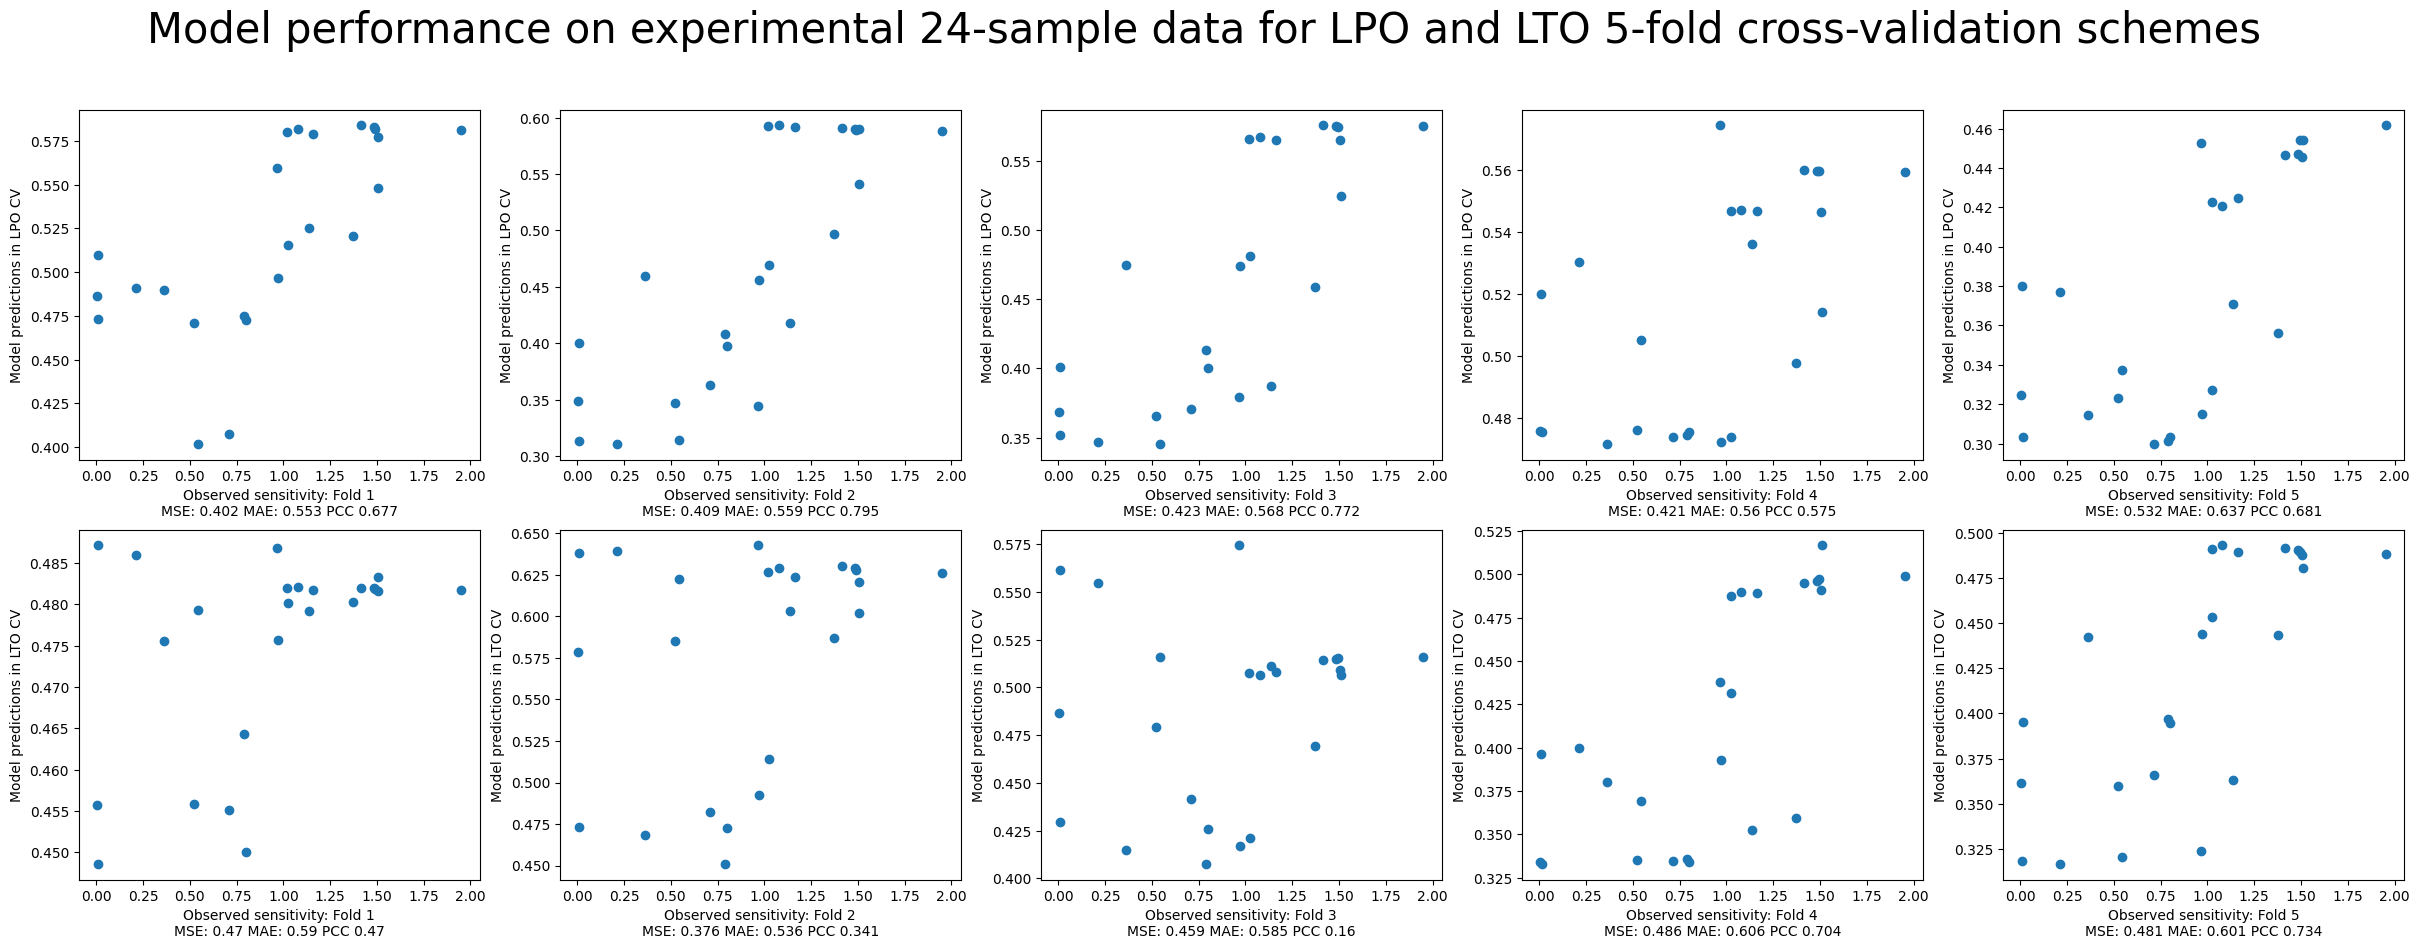

In [50]:
test_set  = Dataset_from_pd(df_test, drug_data, cell_data)
test_dl = DataLoader(test_set, batch_size=25)
loss_fn = torch.nn.MSELoss()
mae_fn = torch.nn.L1Loss()
with torch.no_grad():
    for i, data in enumerate(test_dl):
        inputs, labels = data
labels = labels.to("cpu").view(-1)

plt.subplots(figsize=(30, 10))

test_pair_records = np.load("test_pair_outputs.npy")
for i in range(5):
    outputs = test_pair_records[i].reshape(-1)
    outputs = torch.tensor(outputs)
    loss_test = round(loss_fn(outputs, labels).item(), 3)
    mae_test = round(mae_fn(outputs, labels).item(),3)
    vx = outputs - torch.mean(outputs)
    vy = labels - torch.mean(labels)
    pcc_test = np.round(torch.sum(vx * vy) / (torch.sqrt(torch.sum(vx ** 2)) * torch.sqrt(torch.sum(vy ** 2))).item(), 3)
    plt.subplot(2,5,i+1)
    plt.scatter(labels, outputs)
    plt.ylabel("Model predictions in LPO CV")
    plt.xlabel("Observed sensitivity: Fold {}\n".format(i+1) +"MSE: {} MAE: {} PCC {}".format(loss_test,mae_test,pcc_test))


test_triplet_records = np.load("test_triplet_outputs.npy")
for i in range(5):
    outputs = test_triplet_records[i].reshape(-1)
    outputs = torch.tensor(outputs)
    loss_test = round(loss_fn(outputs, labels).item(), 3)
    mae_test = round(mae_fn(outputs, labels).item(),3)
    vx = outputs - torch.mean(outputs)
    vy = labels - torch.mean(labels)
    pcc_test = np.round(torch.sum(vx * vy) / (torch.sqrt(torch.sum(vx ** 2)) * torch.sqrt(torch.sum(vy ** 2))).item(), 3)
    plt.subplot(2,5,i+1+5)
    plt.scatter(labels, outputs)
    plt.ylabel("Model predictions in LTO CV")
    plt.xlabel("Observed sensitivity: Fold {}\n".format(i+1) +"MSE: {} MAE: {} PCC {}".format(loss_test,mae_test,pcc_test))


plt.suptitle("Model performance on experimental 24-sample data for LPO and LTO 5-fold cross-validation schemes", size=30)

plt.savefig("../figures/cv_results")


In [151]:
model.eval()
with torch.no_grad():
    for i, data in enumerate(test_dl):
        inputs, labels = data
        inputs = inputs.to(device=device)
        labels = labels.to(device=device)
        outputs = model(inputs)
        loss_test = loss_fn(outputs, labels).item()
        mae_test = mae_fn(outputs, labels).item()
        vx = voutputs - torch.mean(outputs)
        vy = vlabels - torch.mean(labels)
        pcc_test = torch.sum(vx * vy) / (torch.sqrt(torch.sum(vx ** 2)) * torch.sqrt(torch.sum(vy ** 2))).item()
        print(labels.to("cpu").numpy())


[[1.0249797 ]
 [0.7882507 ]
 [0.7118246 ]
 [0.54228866]
 [0.970456  ]
 [0.7996898 ]
 [0.52382165]
 [0.2116317 ]
 [1.9516927 ]
 [1.4921523 ]
 [1.4859641 ]
 [1.4145942 ]
 [0.36284554]
 [0.01175009]
 [0.00413306]
 [0.01023069]
 [1.5044664 ]
 [1.1610321 ]
 [1.0217108 ]
 [1.0783128 ]
 [1.508316  ]
 [1.3742086 ]
 [1.138154  ]
 [0.96429497]]


In [95]:
model = AE_DNN([770,256,256,256, 128,128,128,64,64,64])
model.load_state_dict(torch.load("../models/ae_dnn.pt"))

<All keys matched successfully>

     cell_line   drugA_name    drugB_name  drugA_conc  drugB_conc    target  \
20  ACH-000768  Saracatinib  Rocilinostat      0.0125       4.395  1.508316   
21  ACH-000768  Saracatinib  Rocilinostat       0.025        8.79  1.374209   
22  ACH-000768  Saracatinib  Rocilinostat      0.0375      13.185  1.138154   
23  ACH-000768  Saracatinib  Rocilinostat        0.05       17.58  0.964295   

         std  
20  0.624652  
21   0.68497  
22  0.322111  
23   0.22007  




































































































    cell_line drugA_name drugB_name  drugA_conc  drugB_conc    target  \
0  ACH-000768     GW9662   PD168393       2.975      4.0675   1.02498   
1  ACH-000768     GW9662   PD168393        5.95       8.135  0.788251   
2  ACH-000768     GW9662   PD168393       8.925     12.2025  0.711825   
3  ACH-000768     GW9662   PD168393        11.9       16.27  0.542289   

        std  
0  0.213373  
1  0.105838  
2  0.177698  
3  0.18

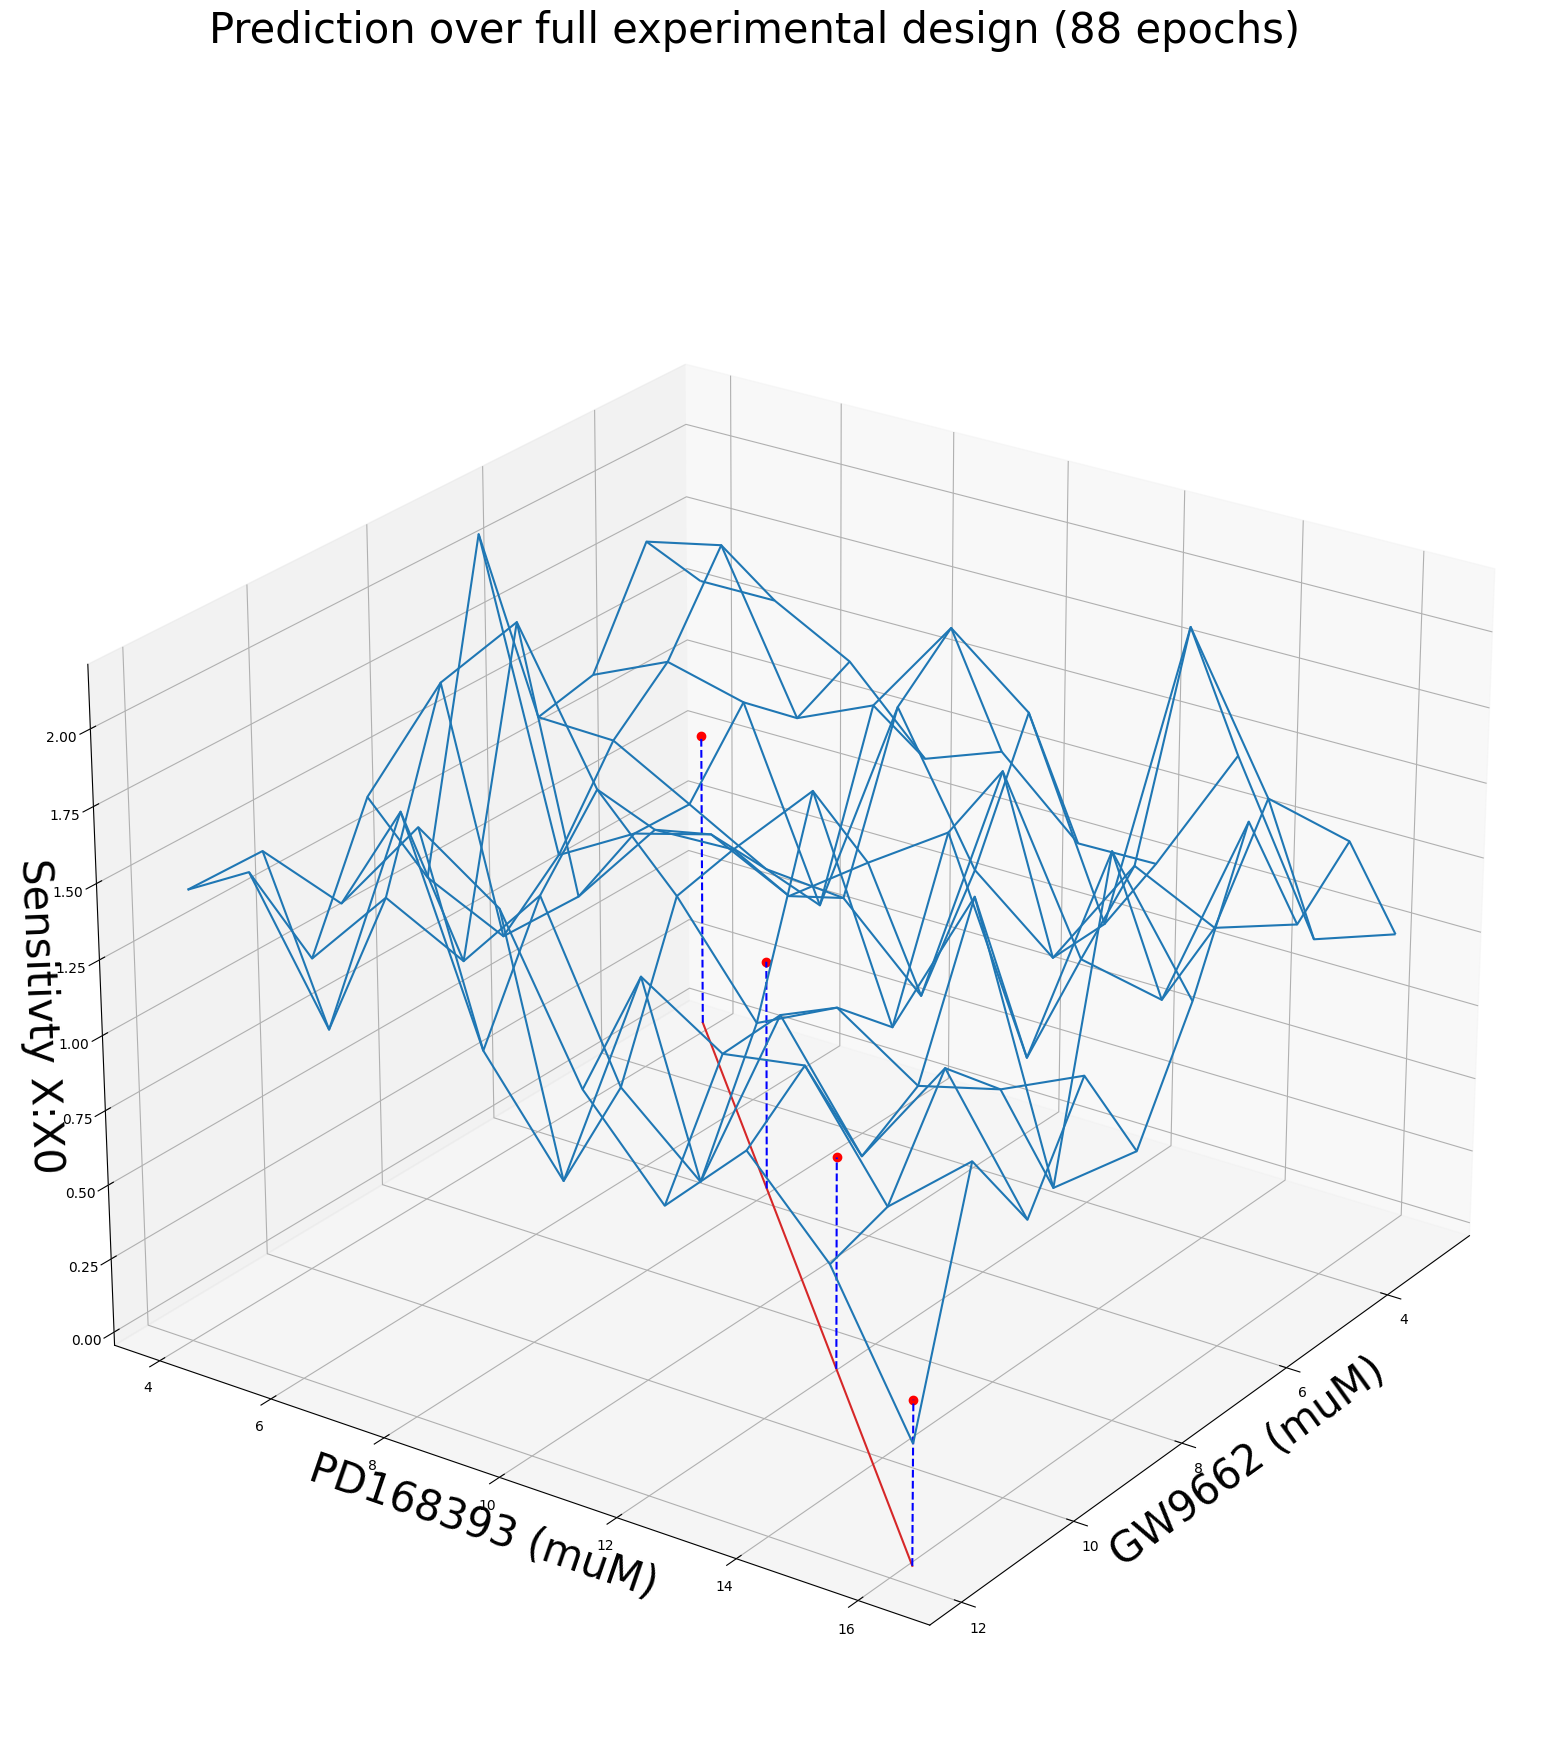

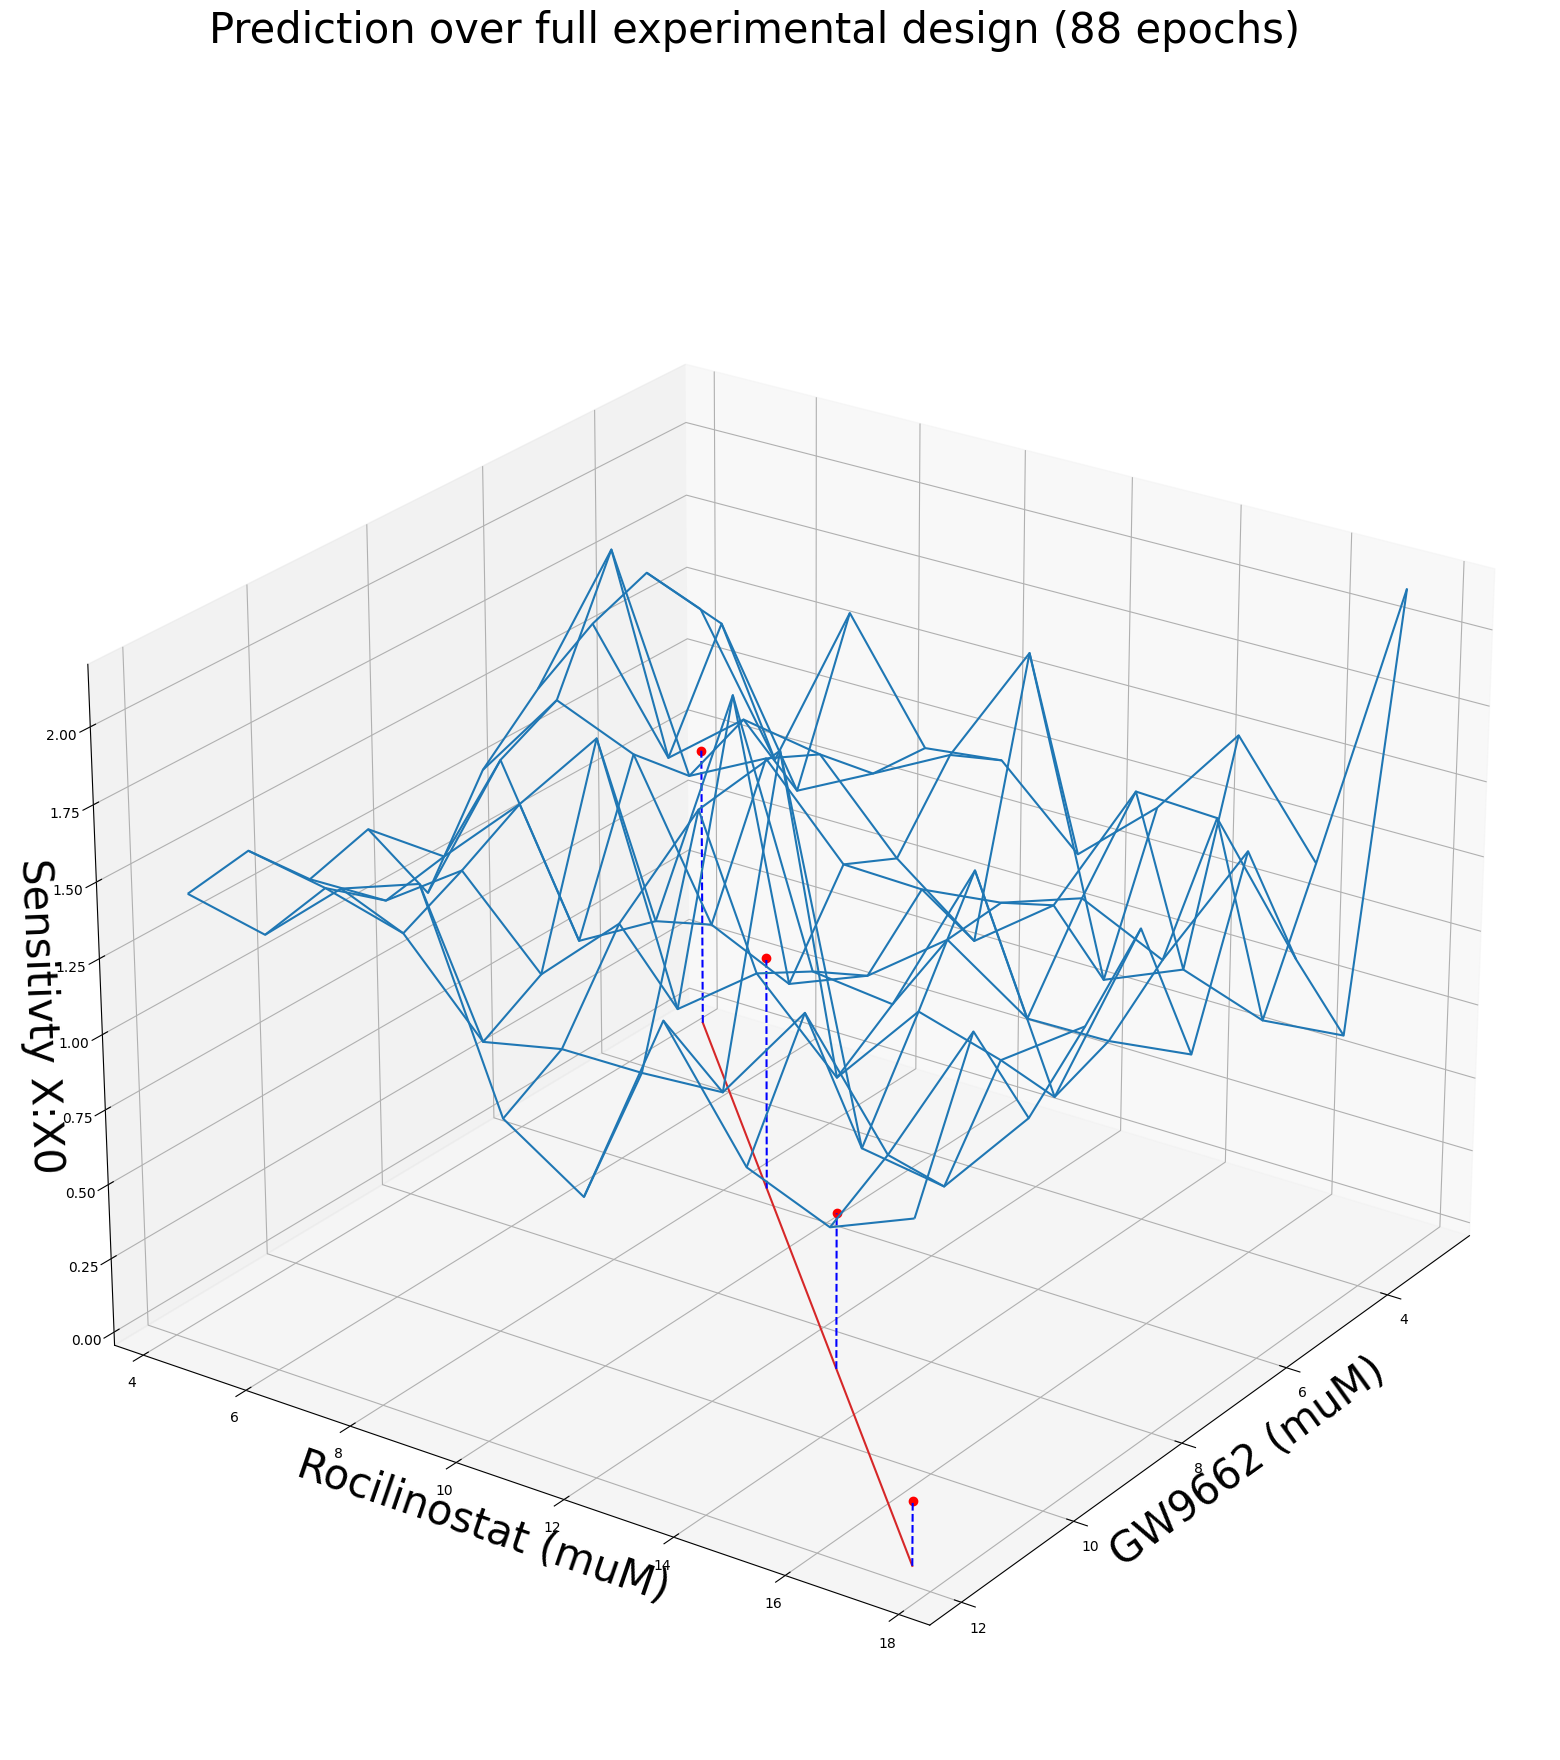

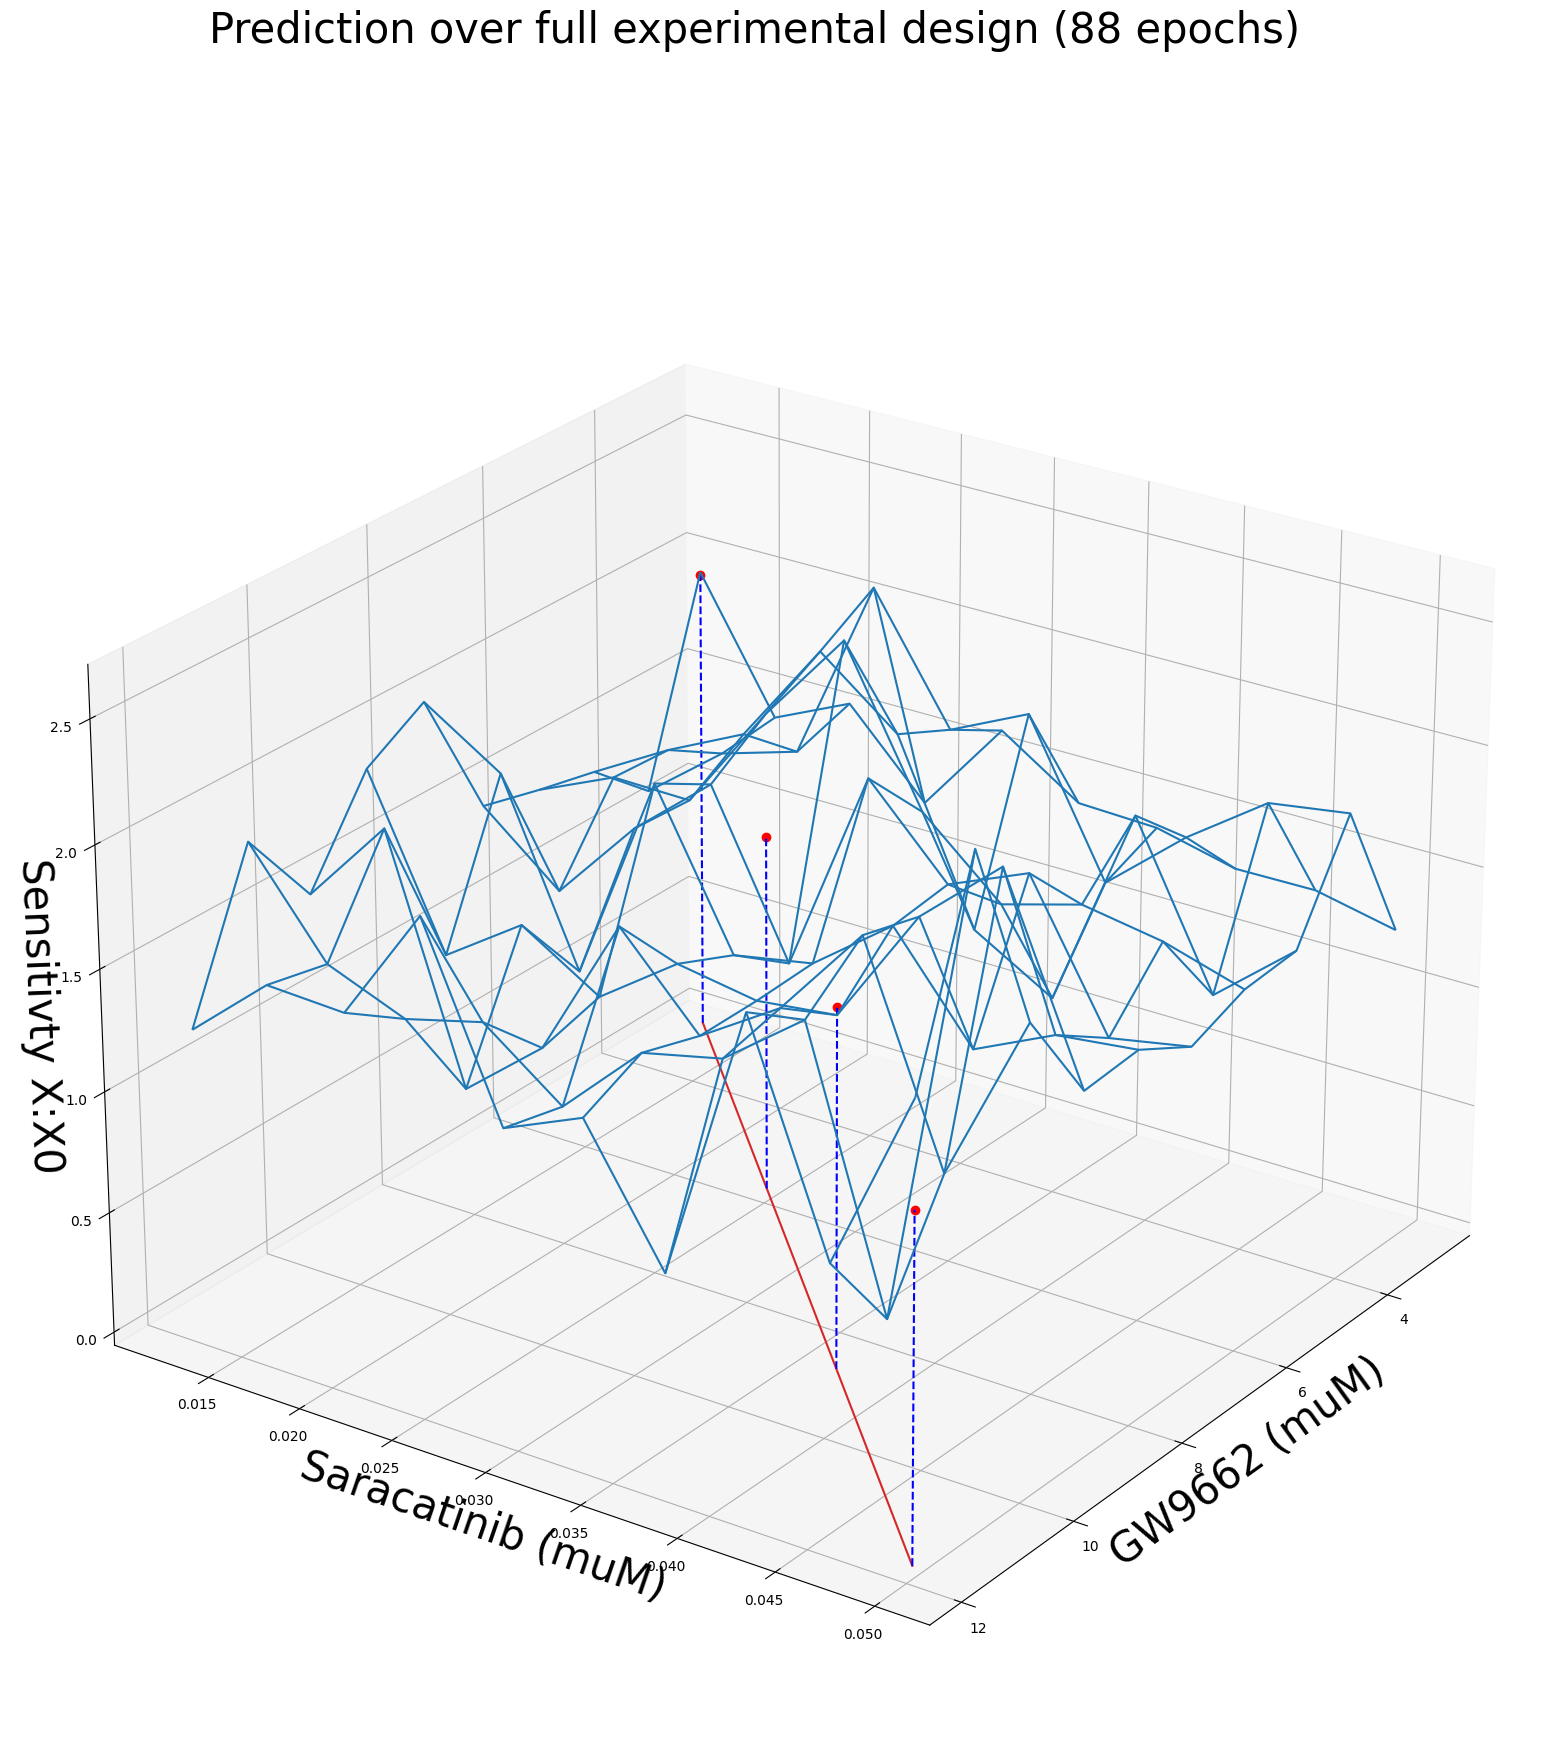

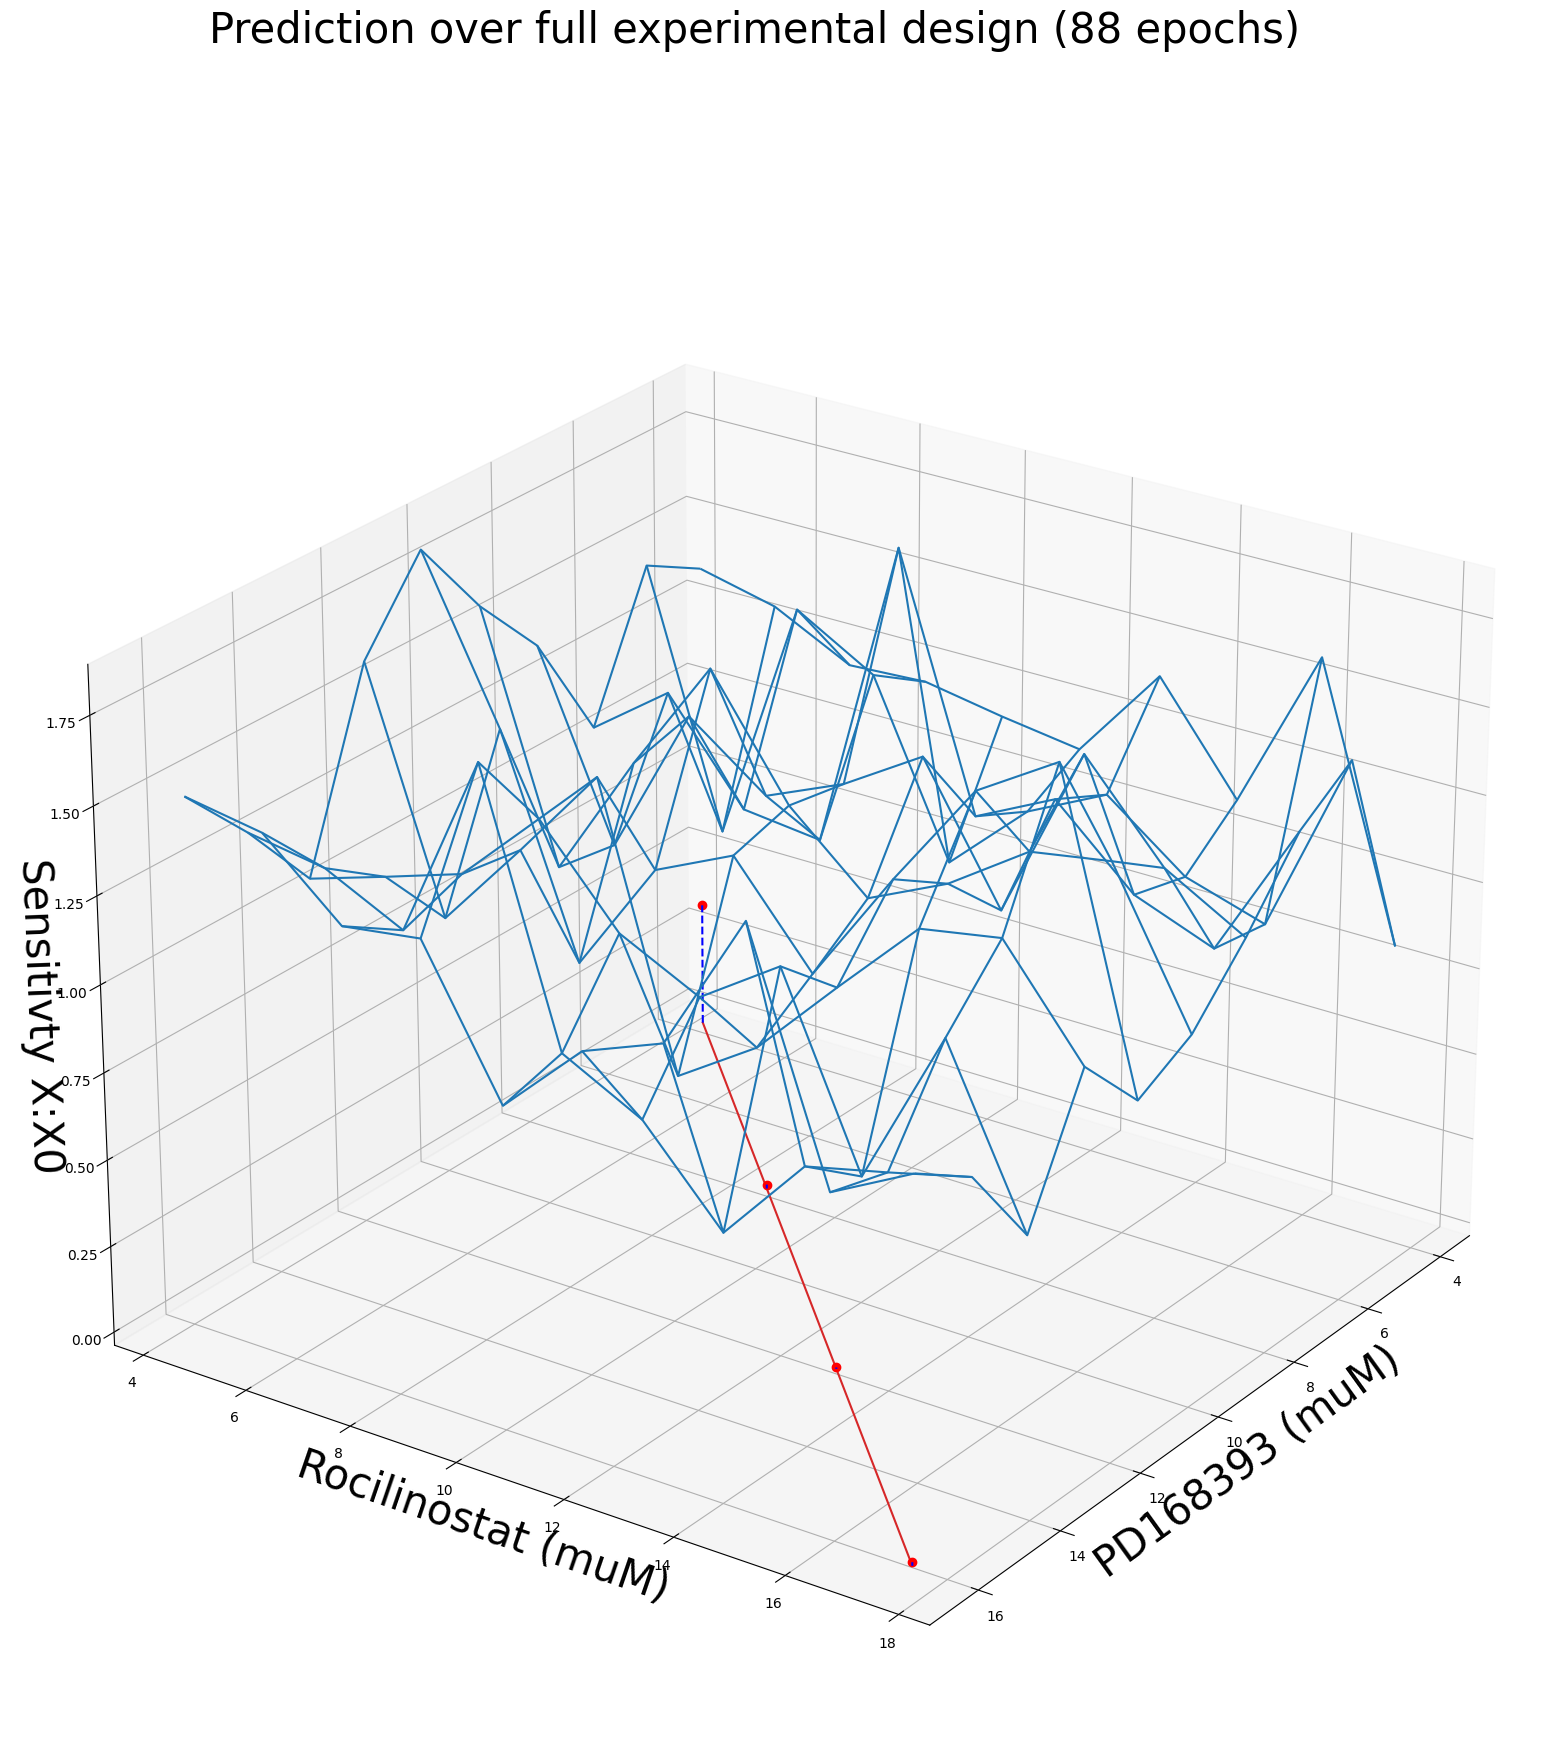

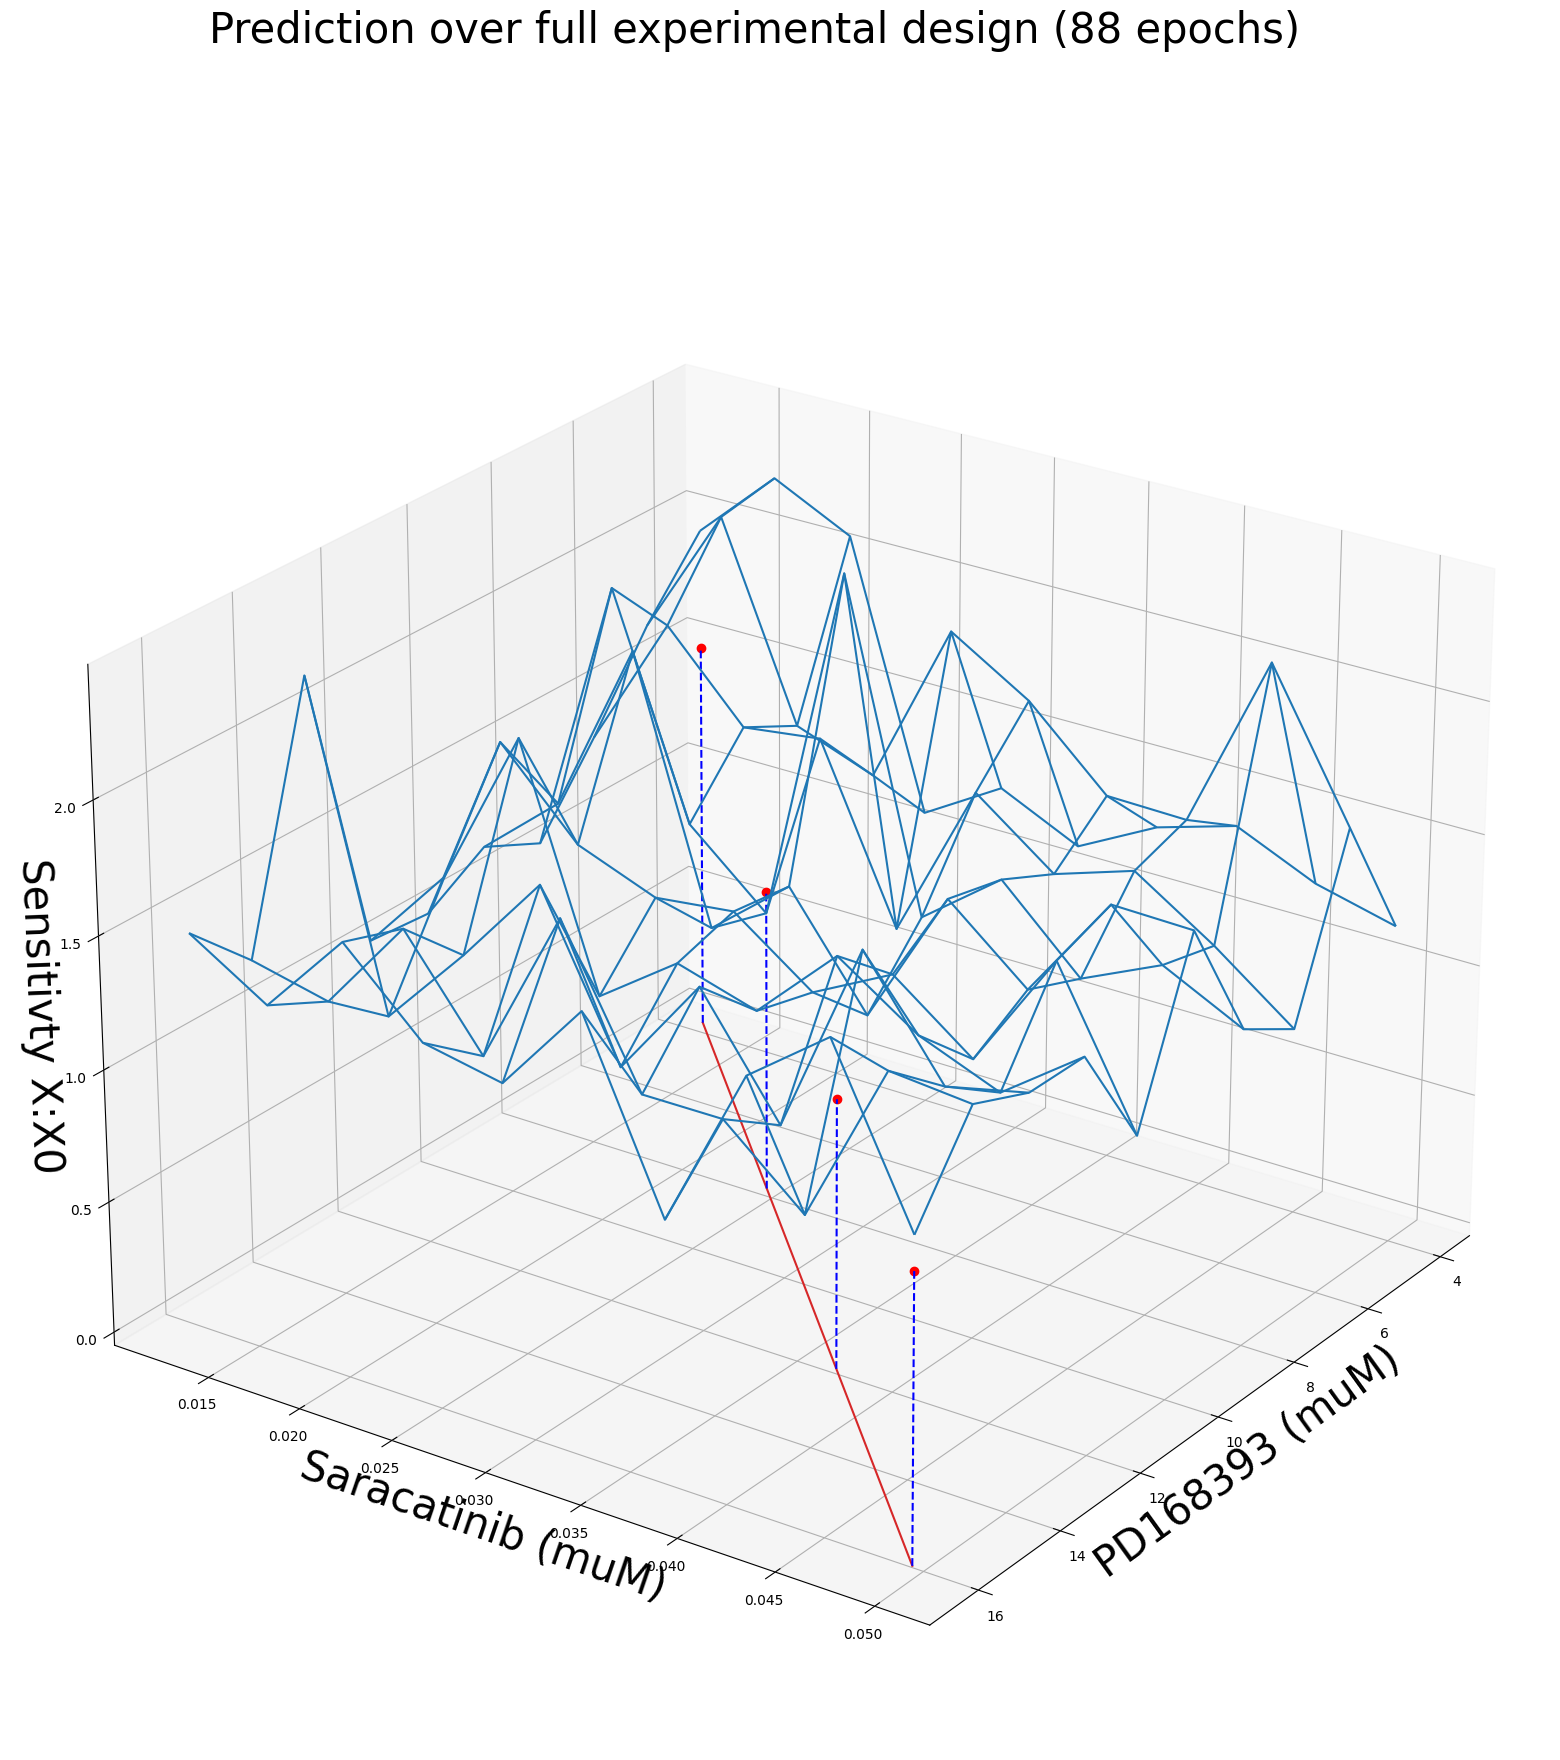

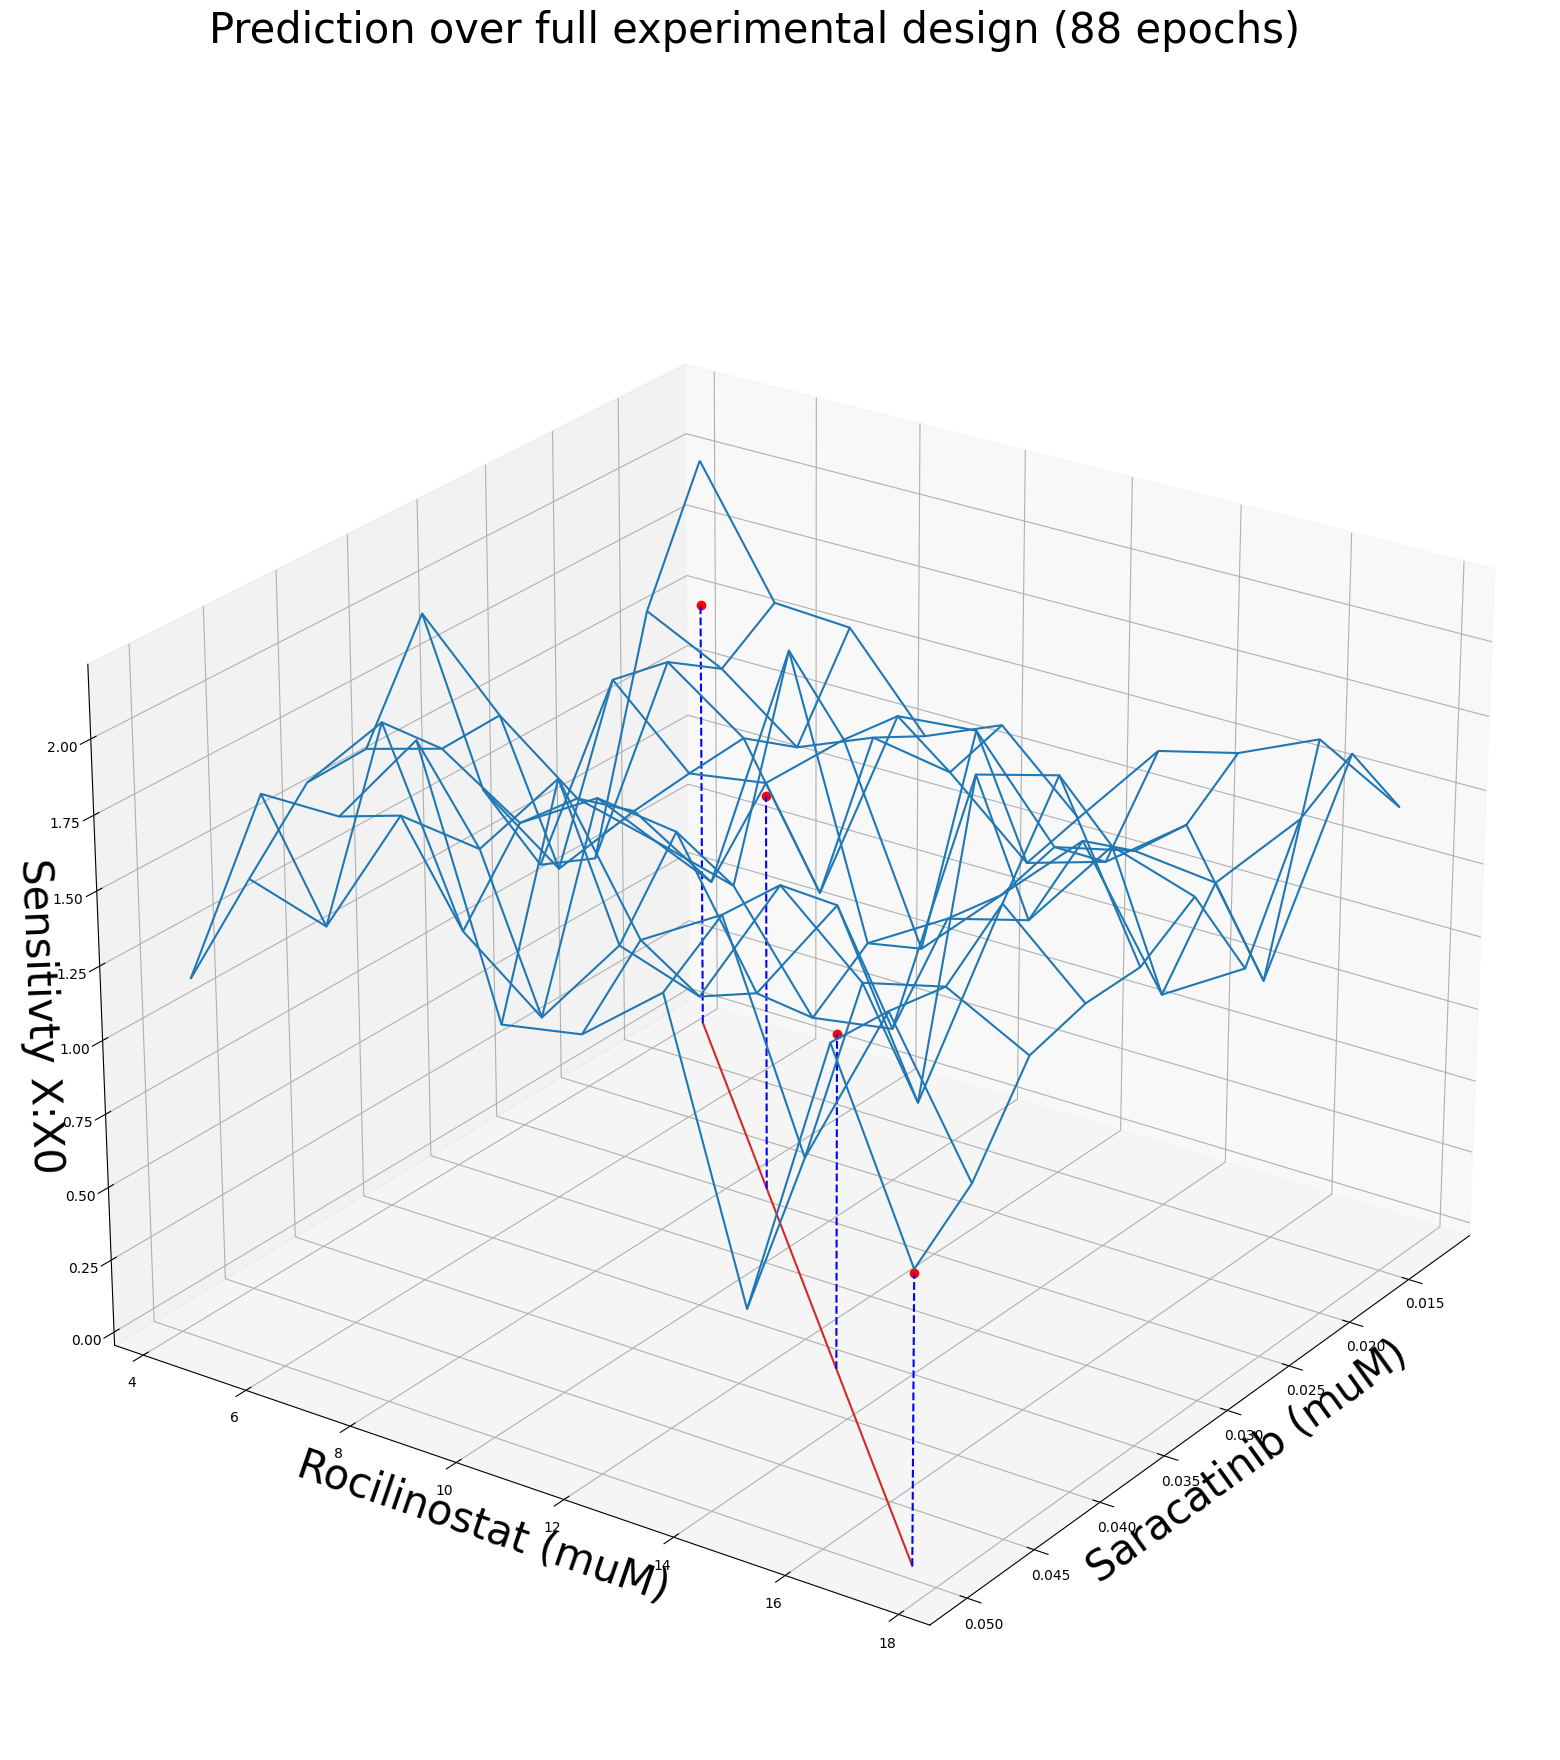

In [128]:
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
# print(df_test)
for i in range(6):
    print(data)
    data = df_test.iloc[4*i:4*(i+1)]
    fig = plt.figure(figsize=(20,20))
    ax = fig.add_subplot(projection='3d')
    ax.stem(data.drugA_conc, data.drugB_conc, data.target, markerfmt='or', linefmt="--b")
    Z = np.empty((10,10))
    A = np.linspace(data.drugA_conc.min(),data.drugA_conc.max(), 10)
    B = np.linspace(data.drugB_conc.min(),data.drugB_conc.max(), 10)
    X,Y = np.meshgrid(A,B)
    # Conc = np.concatenate([X,Y]).reshape((-1,2), order='C')
    for m in range(X.shape[0]):
        for n in range(X.shape[1]):
            sample = df_test.iloc[i:i+1, 0:3]
            sample["drugA_conc"] = X[m,n]
            sample["drugB_conc"] = Y[m,n]
            sample["target"] = df_test.iloc[i:i+1, 5:6]
            sample_set  = Dataset_from_pd(sample, drug_data, cell_data)
            sample, label = next(iter(DataLoader(sample_set)))
            predict = model(sample)
            Z[m,n] = predict
    
    # ax.scatter()

    # Plot a basic wireframe.
    ax.set_xlabel("{} (muM)".format(data.drugA_name.iloc[0]), size=30)
    ax.set_ylabel("{} (muM)".format(data.drugB_name.iloc[0]), size=30)
    ax.set_zlabel("Sensitivty X:X0", size=30)
    ax.plot_wireframe(X, Y, Z, rstride=1, cstride=1)
    ax.view_init(25, 35)
    plt.suptitle("Prediction over full experimental design (88 epochs)", size=30)

    # ax.view_init(0, 90)
    # ax.view_init(0, 0)

plt.show()